## Resources

* [David Robinson's analysis](https://github.com/dgrtwo/data-screencasts/blob/master/space-launches.Rmd)

In [1]:
import pandas as pd
import requests

from plotnine import *
from siuba.siu import _
from siuba.tidy import *
from siuba.dply.forcats import fct_collapse, fct_lump, fct_reorder

from qgrid import show_grid

Description
----------------
* launch data over time
* shift from private to commercial
* highlighting some disasters

In [2]:
agencies = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-01-15/agencies.csv")
launches = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-01-15/launches.csv")


launches["launch_date_dt"] = pd.to_datetime(launches.launch_date, errors = 'coerce')

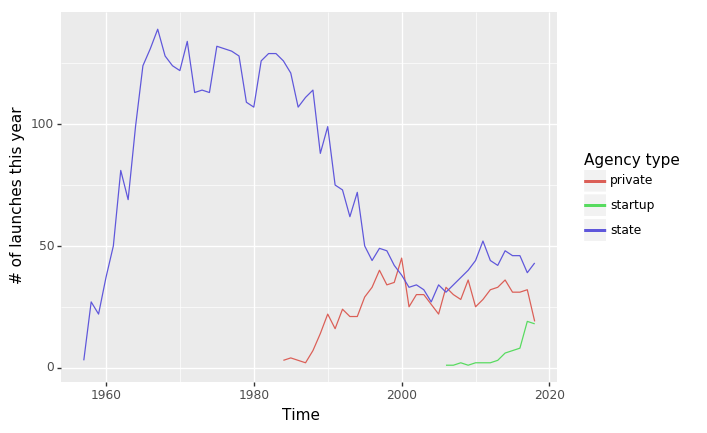

<ggplot: (304739427)>

In [3]:
(launches
  >> count(_, _.launch_year, _.agency_type)
  >> ggplot(aes("launch_year", "n", color = "agency_type"))
   + geom_line()
   + labs(x = "Time", y = "# of launches this year", color = "Agency type")
  )

In [4]:
from datetime import datetime
datetime.now()

datetime.datetime(2019, 3, 12, 9, 45, 6, 878058)

In [5]:
launches >> count(_, _.agency_type, _.agency, sort = True)

agencies >> count(_, _.state_code, wt = _.count, sort = True)

launches_processed = (launches
  >> filter(_, _.launch_date_dt <= datetime.now())
  >> mutate(_, state_code = fct_collapse(
       _.state_code,
       {"RU": ["SU", "RU"], "FR": "F", "JP": "J", "IT": "I"}
     ))
   >> mutate(_, state_name = fct_lump(_.state_code, 6).fillna('Other'))
  )


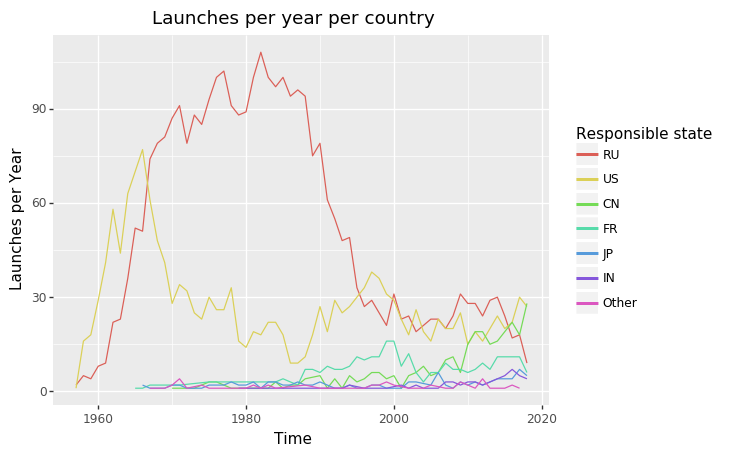

<ggplot: (304091582)>

In [6]:
(launches_processed
  >> count(_, "launch_year", "state_name")
  >> mutate(_, state_name = fct_reorder(_.state_name, -_.n, np.sum))
  >> ggplot(aes("launch_year", "n", color = "state_name"))
   + geom_line()
   + labs(x = "Time", y = "Launches per Year", color = "Responsible state",
          title = "Launches per year per country",
          subtitle = "Combines Soviet Union (pre-1990) with Russia")
  )

## Focus on private + startup launches

# Misc

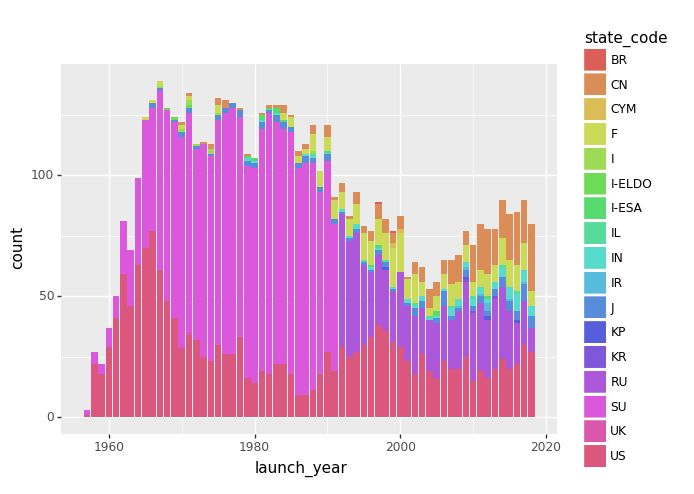

<ggplot: (304108741)>

In [7]:
#pd.to_datetime(launches.launch_date)
#launches >> filter("launch_date")
(launches
  >> count(_, "state_code", sort = True)
  >> mutate(_,
       state_label = if_else(_.n > 100, _.state_code, 'other')      
       )
  >> right_join(_, launches, on = "state_code")
  >> ggplot(aes("launch_year", fill = "state_code"))
   + geom_bar()
  )
